<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


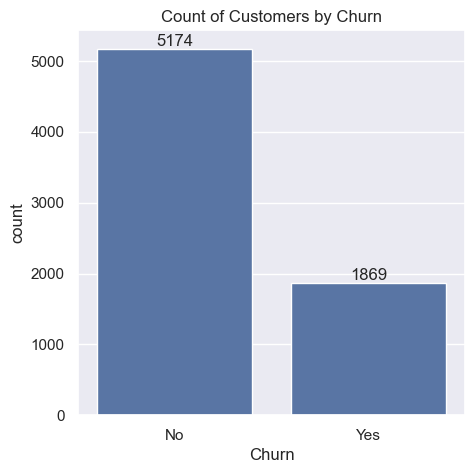

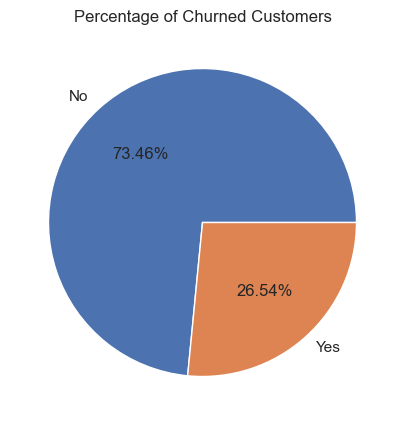

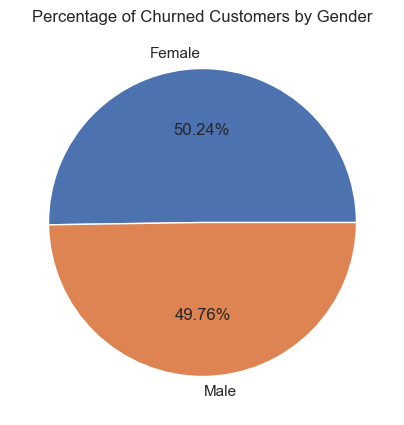

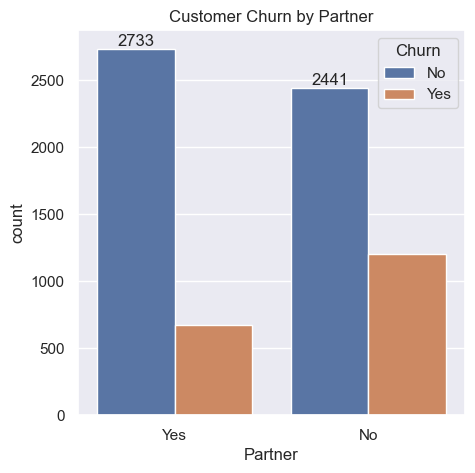

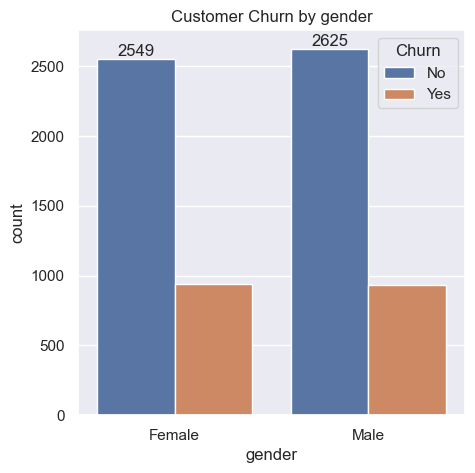

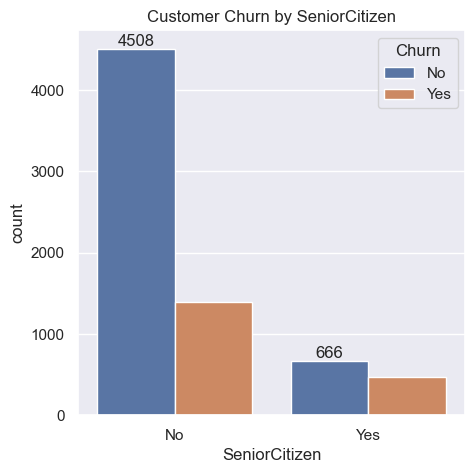

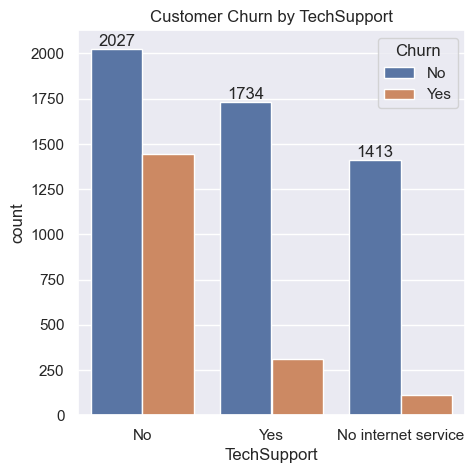

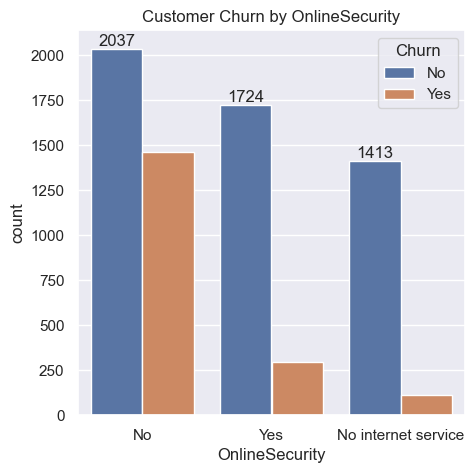

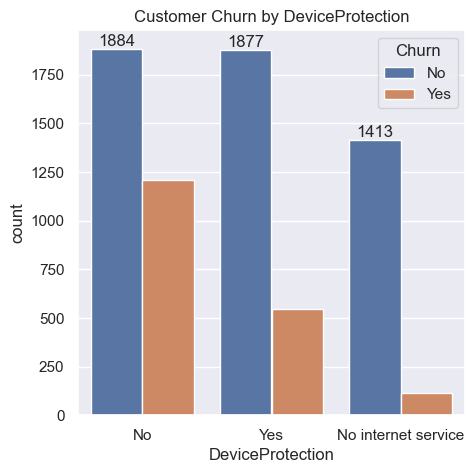

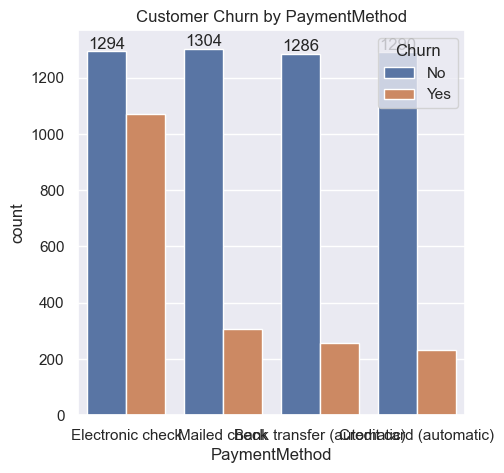

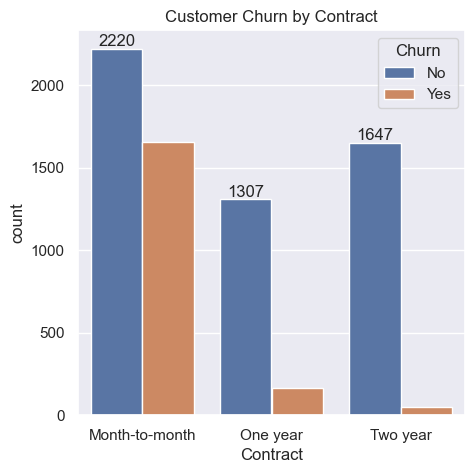

Decision Tree Test Accuracy: 0.7363937529578798
Decision Tree Train Accuracy: 0.9983772819472616
Random Forest Test Accuracy: 0.8882447665056361
Random Forest Train Accuracy: 0.9984812922822035
XGBoost Test Accuracy: 0.8524959742351047
XGBoost Train Accuracy: 0.9393897556261218
KNN Test Accuracy: 0.782608695652174
KNN Train Accuracy: 0.8359795664779788
SVM Test Accuracy: 0.7584541062801933
SVM Train Accuracy: 0.7394725942289107
Cross-Validation Mean Accuracy: 0.8974688231846699


C:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Stacking Test Accuracy: 0.8563607085346215
KNN Evaluation: {'Accuracy': 0.782608695652174, 'Precision': 0.7362030905077263, 'Recall': 0.8713259307642064, 'F1': 0.7980855518994915, 'AUC': 0.8630633987801447, 'Confusion Matrix': array([[1096,  478],
       [ 197, 1334]], dtype=int64)}


In [11]:
# Libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import randint as sp_randint
from sklearn.decomposition import PCA
import pickle as pk

# Set visualization style
%matplotlib inline
sns.set()

# Load dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Data Overview
df.info()
df.describe()
df.head()

# Handle missing data
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.fillna(df['TotalCharges'].mean())
df['TotalCharges'] = df['TotalCharges'].replace(' ', '0').astype(float)

# Senior Citizen data correction
df['SeniorCitizen'] = df['SeniorCitizen'].apply(lambda x: 'Yes' if x == 1 else 'No')

# Data visualization: Churn analysis
plt.figure(figsize=(5,5))
ax = sns.countplot(x='Churn', data=df)
ax.bar_label(ax.containers[0])
plt.title("Count of Customers by Churn")
plt.show()

# Churn percentage pie chart
plt.figure(figsize=(5,5))
churn_counts = df.groupby("Churn").agg({'Churn': 'count'})
plt.pie(churn_counts['Churn'], labels=churn_counts.index, autopct="%1.2f%%")
plt.title("Percentage of Churned Customers")
plt.show()

# Gender distribution for churned customers
plt.figure(figsize=(5,5))
churned_customers = df[df['Churn'] == 'Yes']
gender_churn = churned_customers.groupby('gender').agg({'gender': 'count'})
plt.pie(gender_churn['gender'], labels=gender_churn.index, autopct="%1.2f%%")
plt.title("Percentage of Churned Customers by Gender")
plt.show()

# Visualizations: Customers by Partner, Senior Citizen, and other features
features_to_visualize = ['Partner', 'gender', 'SeniorCitizen', 'TechSupport', 'OnlineSecurity', 'DeviceProtection', 'PaymentMethod', 'Contract']
for feature in features_to_visualize:
    plt.figure(figsize=(5,5))
    ax = sns.countplot(x=feature, data=df, hue='Churn')
    ax.bar_label(ax.containers[0])
    plt.title(f'Customer Churn by {feature}')
    plt.show()

# Data Preprocessing: Label Encoding and One-Hot Encoding
df1 = df.copy()
label_encode_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
one_hot_encode_columns = ['MultipleLines', 'OnlineBackup', 'InternetService', 'OnlineSecurity', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']

# Label Encoding
le = LabelEncoder()
for col in label_encode_columns:
    df1[col] = le.fit_transform(df1[col])

# One-Hot Encoding
for col in one_hot_encode_columns:
    one_hot = pd.get_dummies(df1[col], prefix=col, drop_first=True)
    df1 = pd.concat([df1, one_hot], axis=1)
    df1.drop(col, axis=1, inplace=True)

# Drop unnecessary columns
df1.drop('customerID', axis=1, inplace=True)

# Log Transformation to reduce skewness
df1['MonthlyCharges'] = np.log1p(df1['MonthlyCharges'])
df1['TotalCharges'] = np.log1p(df1['TotalCharges'])

# Standardization
scaler = StandardScaler()
df1['tenure'] = scaler.fit_transform(df1[['tenure']])

# Split data into features (X) and target (y)
X = df1.drop(columns=['Churn'])
y = df1['Churn']

# Train-test split (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

# Decision Tree Classifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
print("Decision Tree Test Accuracy:", dt.score(X_test, y_test))
print("Decision Tree Train Accuracy:", dt.score(X_train, y_train))

# Random Oversampling to address class imbalance
oversample = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversample.fit_resample(X, y)

# Re-split the oversampled data
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_resampled, y_resampled, train_size=0.7, random_state=42)

# Random Forest Classifier
rf = RandomForestClassifier()
rf.fit(X_train_res, y_train_res)
print("Random Forest Test Accuracy:", rf.score(X_test_res, y_test_res))
print("Random Forest Train Accuracy:", rf.score(X_train_res, y_train_res))

# XGBoost Classifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train_res, y_train_res)
print("XGBoost Test Accuracy:", xgb_model.score(X_test_res, y_test_res))
print("XGBoost Train Accuracy:", xgb_model.score(X_train_res, y_train_res))

# K-Nearest Neighbors (KNN)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_res, y_train_res)
print("KNN Test Accuracy:", knn.score(X_test_res, y_test_res))
print("KNN Train Accuracy:", knn.score(X_train_res, y_train_res))

# Support Vector Machine (SVM)
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_res, y_train_res)
print("SVM Test Accuracy:", svm_model.score(X_test_res, y_test_res))
print("SVM Train Accuracy:", svm_model.score(X_train_res, y_train_res))

# Cross-Validation with Random Forest
kfold = KFold(n_splits=5, shuffle=True)
cv_results = cross_val_score(rf, X_resampled, y_resampled, cv=kfold)
print("Cross-Validation Mean Accuracy:", cv_results.mean())

# PCA (Dimensionality Reduction)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(MinMaxScaler().fit_transform(X_resampled))
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_resampled, train_size=0.7, random_state=42)

# Stacking Classifier
stacking_clf = StackingClassifier(estimators=[('dt', DecisionTreeClassifier()), ('lr', LogisticRegression())], final_estimator=LogisticRegression())
stacking_clf.fit(X_train_res, y_train_res)
print("Stacking Test Accuracy:", stacking_clf.score(X_test_res, y_test_res))

# Model Evaluation Function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    cm = confusion_matrix(y_test, y_pred)
    
    return {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1, 'AUC': auc, 'Confusion Matrix': cm}

# Evaluate the KNN Model
knn_eval = evaluate_model(knn, X_test_res, y_test_res)
print("KNN Evaluation:", knn_eval)

# Save the trained model with pickle
with open('trained_model.pkl', 'wb') as model_file:
    pk.dump(rf, model_file)
